![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 017</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">過去コンペの予測ラベル</li>
    <li style = "color:#4c1c84;
                font-size:14px">TFIDF</li>
    <li style = "color:#4c1c84;
                font-size:14px">SVR</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")

In [2]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import RobertaTokenizer

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

# Model
import lightgbm as lgb
from sklearn.svm import SVC
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import cuml
from cuml.svm import SVR

2022-01-19 03:58:21.881428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import torch

config = {
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 3,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "017_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 64,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": False,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 16,
        "shuffle": False,
        "num_workers": 4,
        "pin_memory": True,
        "drop_last": False,
    },

    "valid_loader": {
        "batch_size": 4,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "roberta-base",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-5,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.BCEWithLogitsLoss",
}

config = Box(config)
config.tokenizer = AutoTokenizer.from_pretrained(config.backbone.name)
config.model = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/017_exp
OUTPUT_DIR is ../data/interim/017_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [5]:
# Seed固定
seed_everything(config.seed)

42

In [6]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

In [7]:
## Tokenizer & Model Save
config.tokenizer.save_pretrained(OUTPUT_DIR/f"{config.backbone.name}")
pretrain_model = RobertaModel.from_pretrained('roberta-base')
pretrain_model.save_pretrained(OUTPUT_DIR/f"{config.backbone.name}")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
pretrain_model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [9]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [10]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


<br>
<h2 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Ruddit
</h2>
<br>

In [11]:
train_df = pd.read_csv("../data/external/Ruddit/Dataset/ruddit_with_text.csv")
train_df

,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022
2,42g75o,cza23qx,[deleted],https://www.reddit.com/r/changemyview/comments...,0.167
3,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146
4,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083
...,...,...,...,...,...
5833,cu67co,f0i0mqp,They should only censor things that talk badly...,https://i.redd.it/kfsmqzxae3i31.jpg/f0i0mqp/,0.064
5834,cganu1,f80wlxq,> and one of them is a woman. \n\nOH SHIT we b...,https://www.reddit.com/r/worldpolitics/comment...,0.458
5835,cu67co,f8uksbp,how is this flared as US politics,https://i.redd.it/kfsmqzxae3i31.jpg/f8uksbp/,-0.292
5836,cganu1,fa6nc1r,People in Hong Kong must decide if they are go...,https://www.reddit.com/r/worldpolitics/comment...,0.333



<li style = "color:#e60033;
             font-size:20px">
    [deleted]は外した方がいい？
</li>

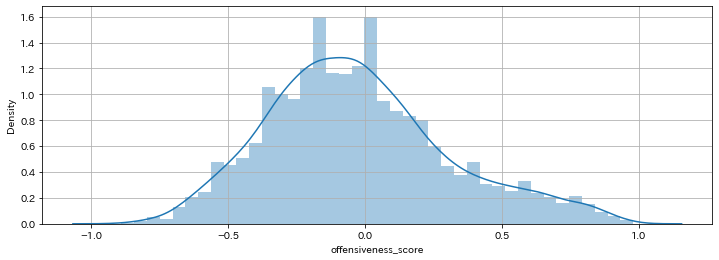

In [12]:
plt.figure(figsize=(12, 4))
sns.distplot(train_df["offensiveness_score"])
plt.grid()
plt.show()

In [13]:
train_df['y'] = (train_df['offensiveness_score'] - train_df.offensiveness_score.min()) / (train_df.offensiveness_score.max() - train_df.offensiveness_score.min()) 


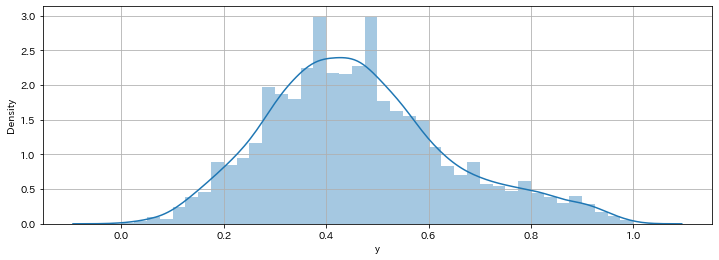

In [14]:
plt.figure(figsize=(12, 4))
sns.distplot(train_df["y"])
plt.grid()
plt.show()

In [15]:
## [deleted]は除去
train_df = train_df[train_df["txt"]!="[deleted]"].reset_index(drop=True)
train_df

,post_id,comment_id,txt,url,offensiveness_score,y
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083,0.431478
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022,0.464133
2,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146,0.397752
3,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083,0.431478
4,42g75o,cza2jj3,>Men and women are not payed less for the same...,https://www.reddit.com/r/changemyview/comments...,-0.042,0.453426
...,...,...,...,...,...,...
5717,cu67co,f0i0mqp,They should only censor things that talk badly...,https://i.redd.it/kfsmqzxae3i31.jpg/f0i0mqp/,0.064,0.510171
5718,cganu1,f80wlxq,> and one of them is a woman. \n\nOH SHIT we b...,https://www.reddit.com/r/worldpolitics/comment...,0.458,0.721092
5719,cu67co,f8uksbp,how is this flared as US politics,https://i.redd.it/kfsmqzxae3i31.jpg/f8uksbp/,-0.292,0.319593
5720,cganu1,fa6nc1r,People in Hong Kong must decide if they are go...,https://www.reddit.com/r/worldpolitics/comment...,0.333,0.654176


<br>
<h1 style = "font-size:60px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Make Dataset
</h1>
<br>

In [16]:
class JigsawDataset:

    def __init__(self, df, max_length, tokenizer, mode):

        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.mode = mode
        
        if self.mode == "train":

            self.text = df["txt"].values
            self.target = df["y"].values
            
        elif self.mode == "valid":
            
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values
            
        else:
            self.text = df["text"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        if self.mode == "train":
                
            text = self.text[idx]
            target = self.target[idx]

            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length"
            )


            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        elif self.mode == "valid":
            
            more_toxic = self.more_toxic[idx]
            less_toxic = self.less_toxic[idx]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length"
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length"
            )

            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]
            more_toxic_token_type_ids = inputs_more_toxic["token_type_ids"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]
            less_toxic_token_type_ids = inputs_less_toxic["token_type_ids"]

            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'more_toxic_token_type_ids': torch.tensor(more_toxic_token_type_ids, dtype=torch.long),
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'less_toxic_token_type_ids': torch.tensor(less_toxic_token_type_ids, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.long)
            }

        else:
            text = self.text[idx]

            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length"
            )


            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            }

In [17]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            max_length=self._cfg.max_length,
            tokenizer=self._cfg.tokenizer,
            mode="train"
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            max_length=self._cfg.max_length,
            tokenizer=self._cfg.tokenizer,
            mode="train"
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df, 
            max_length=self._cfg.max_length,
            tokenizer=self._cfg.tokenizer,
            mode="test"
            )

        return DataLoader(dataset, **self._cfg.test_loader)

In [18]:
## Data Check

sample_dataloader = JigsawDataModule(train_df, val_df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

In [21]:
print("text_ids size", data["text_ids"].size())
print("text_mask size", data["text_mask"].size())
print("text_token_type_ids size", data["text_token_type_ids"].size())
print("target size", data["target"].size())
print("target", data["target"])

outputs = pretrain_model(
    data["text_ids"], 
    data["text_mask"], 
    data["text_token_type_ids"],
    output_hidden_states=True,
    output_attentions=True,
)
print("Embedding size", outputs.last_hidden_state.size())
print("Attention size", outputs.attentions[-1].size())
# print(outputs)

text_ids size torch.Size([16, 256])
text_mask size torch.Size([16, 256])
text_token_type_ids size torch.Size([16, 256])
target size torch.Size([16])
target tensor([0.4315, 0.4641, 0.3978, 0.4315, 0.4534, 0.4647, 0.3828, 0.3533, 0.4759,
        0.5284, 0.4315, 0.4427, 0.4427, 0.4647, 0.4315, 0.3753])
Embedding size torch.Size([16, 256, 768])
Attention size torch.Size([16, 12, 256, 256])


In [22]:
# ## Data Check

# sample_dataloader = JigsawDataModule(train_df, train_df, test_df, config).val_dataloader()
# for data in sample_dataloader:
#     break

In [21]:
# print("text_ids size", data["text_ids"].size())
# print("text_mask size", data["text_mask"].size())
# print("text_token_type_ids size", data["text_token_type_ids"].size())
# print("target size", data["target"].size())
# print("target", data["target"])
# print("Embedding size", pretrain_model(data["text_ids"], data["text_mask"], data["text_token_type_ids"])["last_hidden_state"].size())

In [22]:
# print("text_ids size", data["more_toxic_ids"].size())
# print("text_mask size", data["more_toxic_mask"].size())
# print("text_token_type_ids size", data["more_toxic_token_type_ids"].size())
# print("target size", data["target"].size())
# print("target", data["target"])
# print("Embedding size", pretrain_model(
#     data["more_toxic_ids"], 
#     data["more_toxic_mask"], 
#     data["more_toxic_token_type_ids"])["last_hidden_state"].size())

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Model
</h1>
<br>

In [27]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

def valid_criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=config.margin)(outputs1, outputs2, targets)

In [32]:
class JigsawModel(pl.LightningModule):
    
    def __init__(self, cfg, fold_num):
        
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.train_criterion = nn.BCEWithLogitsLoss()
        self.valid_criterion = valid_criterion
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num
        
    def __build_model(self):
        
        self.base_model = RobertaModel.from_pretrained('roberta-base')
#         self.base_model = RobertaForSequenceClassification.from_pretrained(self.cfg.backbone.name)
        print(f"Use Model: {self.cfg.backbone.name}")
        
        self.layer_norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.2)
        self.head = nn.Sequential(nn.Linear(768, 256),
                                  nn.LeakyReLU(negative_slope=0.01),
                                  nn.Dropout(0.2),
                                  nn.Linear(256, 1))
        
    def forward(self, ids, mask, token_type_ids):
        
        out = self.base_model(
            data["text_ids"], 
            data["text_mask"], 
            data["text_token_type_ids"],
            output_hidden_states=True,
            output_attentions=True,
        )
#         out = self.base_model(input_ids=ids, attention_mask=mask, token_type_ids=token_type_ids)["last_hidden_state"]
        out = torch.mean(out.last_hidden_state ,dim=1)
        out = self.layer_norm(out)
        out = self.drop(out)
        outputs = self.head(out)
        
        return outputs
    
    def training_step(self, batch, batch_idx):
        
        text_ids = batch['text_ids']
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']
        
        outputs = self.forward(text_ids, text_mask, text_token_type_ids)
        eps = 1e-6
        loss = torch.sqrt(self.train_criterion(outputs, targets) + eps)

        return {"loss":loss, "targets":targets}
    
    def training_epoch_end(self, training_step_outputs):
        
        loss_list = []
        target_list = []
        
        for out in training_step_outputs:
            
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            target_list.extend(out["targets"].cpu().detach().numpy())
            
        meanloss = sum(loss_list)/len(loss_list)
        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}
        
        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
    def validation_step(self, batch, batch_idx):
        
        text_ids = batch['text_ids']
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']
        
        outputs = self.forward(text_ids, text_mask, text_token_type_ids)
        eps = 1e-6
        loss = torch.sqrt(self.train_criterion(outputs, targets) + eps)

        return {"loss":loss, "pred":outputs, "targets":targets}
    
    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.append(out["pred"].cpu().detach().numpy())
            target_list.append(out["targets"].cpu().detach().numpy())

        meanloss = sum(loss_list)/len(loss_list)
        pred_list = np.concatenate(pred_list)
        target_list = np.concatenate(target_list)
        
        plt.figure(figsize=(12, 4))
        sns.distplot(pred_list, label="pred")
        sns.distplot(target_list, label="pred")
        plt.legend()
        plt.show()
        
        
#         acc = np.sum(pred_list > 0)/len(pred_list)
#         acc = sum([i > 0 for i in pred_list])/len(pred_list)

        logs = {
            f"valid_loss/fold{self.fold_num+1}":meanloss,
#             f"valid_acc/fold{self.fold_num+1}":acc,
        }

        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
    def test_step(self, batch, batch_idx):

        text_ids = batch['ids']
        text_mask = batch['mask']

        pred = self.forward(text_ids, text_mask)
        return {"pred":pred,}
    
    def test_epoch_end(self, test_step_outputs):

        pred_list = []

        for out in test_step_outputs:
            pred_list.extend([out["pred"].cpu().detach().numpy()])

        logs = {f"pred":pred_list,}

        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(self.parameters(), **self.cfg.optimizer.params)

        self.scheduler = eval(self.cfg.scheduler.name)(optimizer, **self.cfg.scheduler.params)
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

In [33]:
# class JigsawModel(pl.LightningModule):
    
#     def __init__(self, cfg, fold_num):
# #         
#         super().__init__()
#         self.cfg = cfg
#         self.__build_model()
#         self.train_criterion = RMSELoss()
#         self.valid_criterion = valid_criterion
#         self.save_hyperparameters(cfg)
#         self.fold_num = fold_num
        
#     def __build_model(self):
        
#         self.base_model = AutoModel.from_pretrained(self.cfg.backbone.name)
#         print(f"Use Model: {self.cfg.backbone.name}")
        
#         self.layer_norm = nn.LayerNorm(768)
#         self.drop = nn.Dropout(p=0.2)
#         self.head = nn.Sequential(nn.Linear(768, 256),
#                                   nn.LeakyReLU(negative_slope=0.01),
#                                   nn.Dropout(0.2),
#                                   nn.Linear(256, 1))
        
#     def forward(self, ids, mask, token_type_ids):
        
#         out = self.base_model(input_ids=ids, attention_mask=mask, token_type_ids=token_type_ids, output_hidden_states=False)
#         out = self.layer_norm(out[1])
#         out = self.drop(out)
#         outputs = self.head(out)
        
#         return outputs
    
#     def training_step(self, batch, batch_idx):
        
#         text_ids = batch['text_ids']
#         text_mask = batch['text_mask']
#         text_token_type_ids = batch['text_token_type_ids']
#         targets = batch['target']
        
#         outputs = self.forward(text_ids, text_mask, text_token_type_ids)[:, 0]
#         eps = 1e-6
#         loss = torch.sqrt(self.train_criterion(outputs, targets) + eps)

#         return {"loss":loss, "targets":targets}
    
#     def training_epoch_end(self, training_step_outputs):
        
#         loss_list = []
#         target_list = []
        
#         for out in training_step_outputs:
            
#             loss_list.extend([out["loss"].cpu().detach().tolist()])
#             target_list.extend(out["targets"])
            
#         meanloss = sum(loss_list)/len(loss_list)
#         logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}
        
#         self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
#     def validation_step(self, batch, batch_idx):
        
#         more_toxic_ids = batch['more_toxic_ids']
#         more_toxic_mask = batch['more_toxic_mask']
#         more_toxic_token_type_ids = batch['more_toxic_token_type_ids']
#         less_toxic_ids = batch['less_toxic_ids']
#         less_toxic_mask = batch['less_toxic_mask']
#         less_token_type_ids = batch['less_toxic_token_type_ids']
#         targets = batch['target']
        
#         more_toxic_outputs = self.forward(
#             more_toxic_ids,
#             more_toxic_mask, 
#             more_toxic_token_type_ids
#         )
#         less_toxic_outputs = self.forward(
#             less_toxic_ids, 
#             less_toxic_mask, 
#             less_token_type_ids
#         )
        
#         pred = more_toxic_outputs - less_toxic_outputs
#         loss = self.valid_criterion(more_toxic_outputs, less_toxic_outputs, targets)

#         return {"loss":loss, "pred":pred, "targets":targets}
    
#     def validation_epoch_end(self, validation_step_outputs):

#         loss_list = []
#         pred_list = []
#         target_list = []

#         for out in validation_step_outputs:
#             loss_list.extend([out["loss"].cpu().detach().tolist()])
#             pred_list.append(out["pred"].cpu().detach().numpy())
#             target_list.extend(out["targets"])

#         meanloss = sum(loss_list)/len(loss_list)
#         pred_list = np.concatenate(pred_list)
#         acc = np.sum(pred_list > 0)/len(pred_list)
# #         acc = sum([i > 0 for i in pred_list])/len(pred_list)

#         logs = {
#             f"valid_loss/fold{self.fold_num+1}":meanloss,
#             f"valid_acc/fold{self.fold_num+1}":acc,
#         }

#         self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
#     def test_step(self, batch, batch_idx):

#         text_ids = batch['ids']
#         text_mask = batch['mask']

#         pred = self.forward(text_ids, text_mask)
#         return {"pred":pred,}
    
#     def test_epoch_end(self, test_step_outputs):

#         pred_list = []

#         for out in test_step_outputs:
#             pred_list.extend([out["pred"].cpu().detach().numpy()])

#         logs = {f"pred":pred_list,}

#         self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
#     def configure_optimizers(self):

#         optimizer = eval(self.cfg.optimizer.name)(self.parameters(), **self.cfg.optimizer.params)

#         self.scheduler = eval(self.cfg.scheduler.name)(optimizer, **self.cfg.scheduler.params)
        
#         scheduler = {"scheduler": self.scheduler, "interval": "step",}

#         return [optimizer], [scheduler]

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Training
</h1>
<br>

In [34]:
kf = KFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

for fold, (_, val_idx) in enumerate(kf.split(X=train_df, y=train_df["offensiveness_score"])):
    train_df.loc[val_idx, "kfold"] = int(fold)

train_df["kfold"] = train_df["kfold"].astype(int)
train_df.head()

,post_id,comment_id,txt,url,offensiveness_score,y,kfold
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083,0.431478,2
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022,0.464133,3
2,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146,0.397752,3
3,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083,0.431478,4
4,42g75o,cza2jj3,>Men and women are not payed less for the same...,https://www.reddit.com/r/changemyview/comments...,-0.042,0.453426,4


In [35]:
for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)
    df_valid = train_df[train_df.kfold == fold].reset_index(drop=True)
    
    datamodule = JigsawDataModule(df_train, df_valid, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, df_valid, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_loss_fold{fold+1}",
        monitor=f"valid_loss/fold{fold+1}",
        save_top_k=1,
        mode="min",
        save_last=False,
        dirpath=MODEL_DIR,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "Ruddit"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
        deterministic=True,
        logger=[wandb_logger],
        **config.trainer,
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` w

Use Model: roberta-base


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model      │ RobertaModel      │  124 M │
│ 1 │ layer_norm      │ LayerNorm         │  1.5 K │
│ 2 │ drop            │ Dropout           │      0 │
│ 3 │ head            │ Sequential        │  197 K │
│ 4 │ train_criterion │ BCEWithLogitsLoss │      0 │
└───┴─────────────────┴───────────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 499

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/574 0:00:01 • -:--:-- 0.00it/s  

RuntimeError: Input, output and indices must be on the current device